# Estudio de los datos crudos del sensor

## Carga de datos

A partir de este código, lo que voy a hacer es importar los datos crudos del sensor a partir de los diferentes logs que me devuelve el script save_log2.py y que me guarda en mi carpeta de descargas. A la vez de las mediciones con el sensor de la PCB, estoy midiendo mi pulso y saturación con un pulsioximetro externo, estos datos los apunto en el nombre del archivo del log que creo. \
Con este código pretendo extraer los valores reales de frecuencia cardiaca y saturación de oxígeno a partir del nombre del archivo.


In [29]:
#librerias necesarias
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import glob
import os
import pandas as pd
from scipy.signal import find_peaks, butter, filtfilt

In [30]:
# Extraer el valor real de SpO2 y HR del nombre del archivo (por ejemplo: 'pulsioximetro_98_72.csv')
folder_path = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos"

# Buscar todos los archivos CSV en la carpeta
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))


datos_pulsioximetro = {}

for file in csv_files:
    filename = os.path.basename(file)  # Obtener solo el nombre del archivo

    # Buscar saturación y pulso en el nombre del archivo
    match = re.search(r"_(\d+)_(\d+)", filename)
    if match:
        saturacion = int(match.group(1))
        pulso = int(match.group(2))
        datos_pulsioximetro[filename] = {"Saturación (%)": saturacion, "Pulso (BPM)": pulso}

# Convertir a un DataFrame para verlo mejor
df_resultados = pd.DataFrame.from_dict(datos_pulsioximetro, orient="index")

# Mostrar resultados
print(df_resultados)




                             Saturación (%)  Pulso (BPM)
raw_data_92_103_deporte.csv              92          103
raw_data_92_76.csv                       92           76
raw_data_93_100.csv                      93          100
raw_data_93_79.csv                       93           79
raw_data_95_77.csv                       95           77
raw_data_95_77_2.csv                     95           77
raw_data_95_80.csv                       95           80
raw_data_95_83.csv                       95           83
raw_data_95_87_apnea.csv                 95           87
raw_data_95_99.csv                       95           99
raw_data_96_74_papa.csv                  96           74


Una vez tengo los datos extraidos para que luego sea más cómodo acceder a ellos, me pongo a analizar los datos y tratar de sacar valores reales

## Frecuencia cardiaca

He seguido los siguientes pasos: 
- Filtrar y limpiar los datos: Asegurarnos de que los datos de IR y Red están bien alineados en el tiempo y eliminar valores atípicos.
- Aplicar un filtro pasa-bajos: Reducir el ruido en la señal para identificar los picos correctamente.
- Detectar los picos en la señal IR filtrada: Los picos corresponden a los latidos del corazón.
- Calcular la frecuencia cardíaca (BPM):Contar los picos en un intervalo de tiempo y convertirlos a BPM.

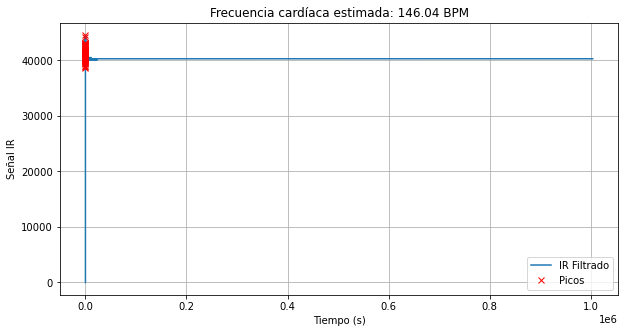

Archivo: raw_data_92_103_deporte.csv - Frecuencia cardíaca estimada: 146.04 BPM


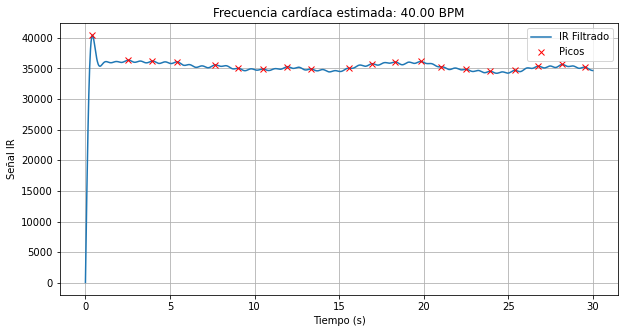

Archivo: raw_data_92_76.csv - Frecuencia cardíaca estimada: 40.00 BPM


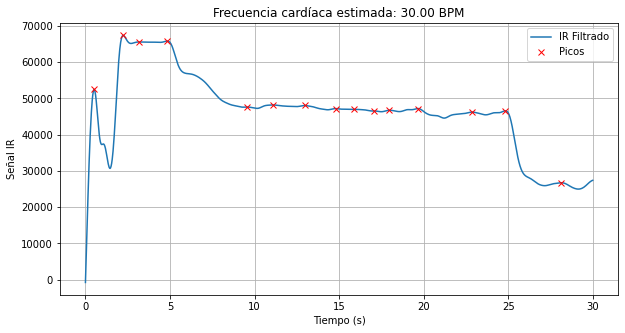

Archivo: raw_data_93_100.csv - Frecuencia cardíaca estimada: 30.00 BPM


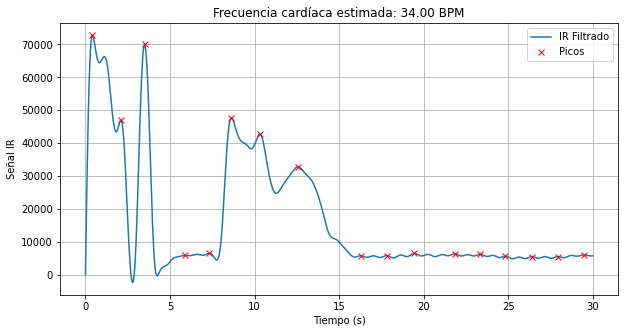

Archivo: raw_data_93_79.csv - Frecuencia cardíaca estimada: 34.00 BPM


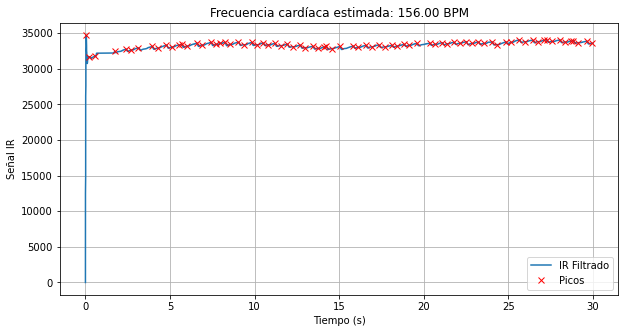

Archivo: raw_data_95_77.csv - Frecuencia cardíaca estimada: 156.00 BPM


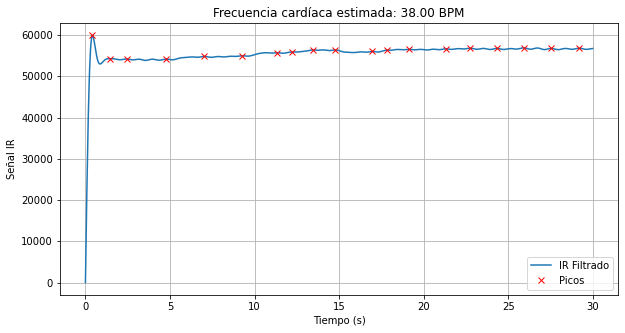

Archivo: raw_data_95_77_2.csv - Frecuencia cardíaca estimada: 38.00 BPM


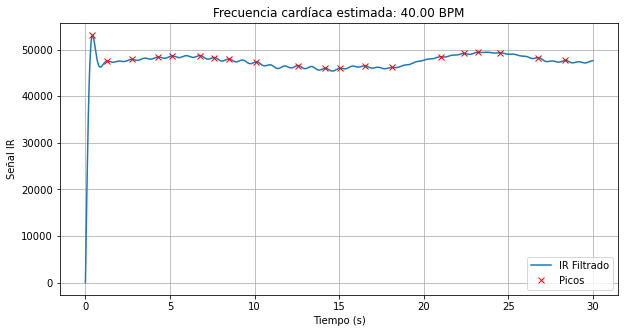

Archivo: raw_data_95_80.csv - Frecuencia cardíaca estimada: 40.00 BPM


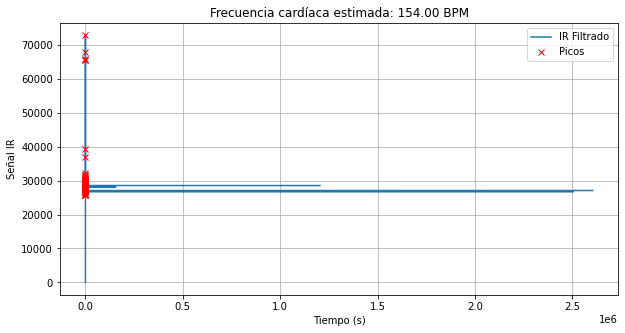

Archivo: raw_data_95_83.csv - Frecuencia cardíaca estimada: 154.00 BPM


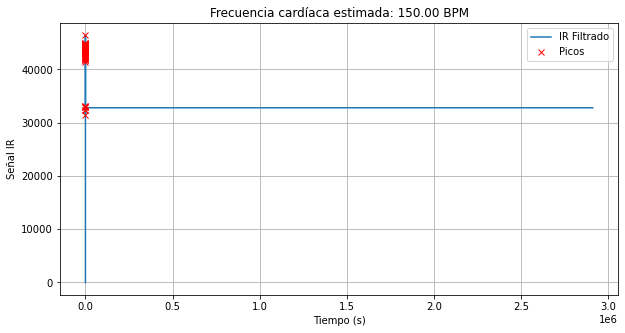

Archivo: raw_data_95_87_apnea.csv - Frecuencia cardíaca estimada: 150.00 BPM


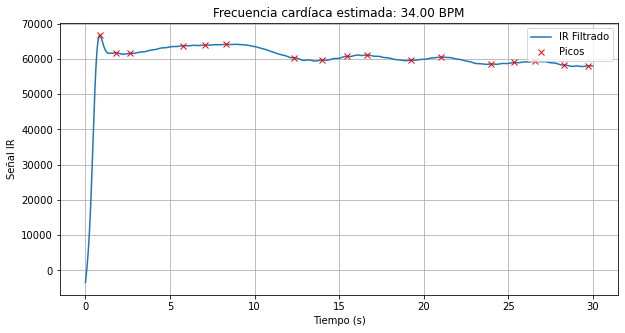

Archivo: raw_data_95_99.csv - Frecuencia cardíaca estimada: 34.00 BPM


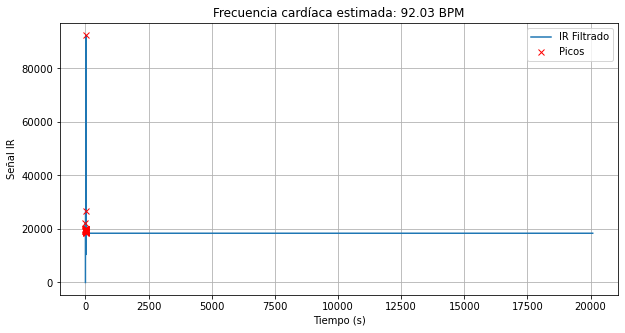

Archivo: raw_data_96_74_papa.csv - Frecuencia cardíaca estimada: 92.03 BPM


In [31]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt

# Parámetros del filtro pasa-bajos
def butter_lowpass_filter(data, cutoff=2.0, fs=100, order=3):
    nyq = 0.5 * fs  # Frecuencia de Nyquist
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

# Procesar cada archivo CSV
for file in csv_files:
    try:
        # Auto-detectar delimitador
        df = pd.read_csv(file, sep=None, engine="python")
        
        # Convertir tiempo de milisegundos a segundos
        df["Tiempo (s)"] = df["Tiempo (ms)"] / 1000  

        # Aplicar filtro a la señal IR
        fs = 100  # Ajustar a la frecuencia de muestreo real
        df["IR_filtrado"] = butter_lowpass_filter(df["IR"], cutoff=2.0, fs=fs)

        # Detectar picos en la señal IR filtrada
        peaks, _ = find_peaks(df["IR_filtrado"], distance=fs//2)

        # Calcular BPM
        tiempo_total = df["Tiempo (s)"].iloc[-1] - df["Tiempo (s)"].iloc[0]
        frecuencia_cardiaca = (len(peaks) / tiempo_total) * 60

        # Graficar señal con picos detectados
        plt.figure(figsize=(10, 5))
        plt.plot(df["Tiempo (s)"], df["IR_filtrado"], label="IR Filtrado")
        plt.plot(df["Tiempo (s)"][peaks], df["IR_filtrado"].iloc[peaks], "rx", label="Picos")
        plt.xlabel("Tiempo (s)")
        plt.ylabel("Señal IR")
        plt.title(f"Frecuencia cardíaca estimada: {frecuencia_cardiaca:.2f} BPM")
        plt.legend()
        plt.grid()
        plt.show()

        print(f"Archivo: {os.path.basename(file)} - Frecuencia cardíaca estimada: {frecuencia_cardiaca:.2f} BPM")
    
    except Exception as e:
        print(f"Error procesando {os.path.basename(file)}: {e}")


En este código anterior, las graficas son muy diferentes entre si porque he guardado logs con versiones diferentes de código para ver cual salia mejor, ya lo cambiaré.

### Análisis a partir de los datos infrarrojos

**¿Qué representan las señales del pulsioxímetro?**
El pulsioxímetro mide la absorción de luz en el tejido usando dos longitudes de onda:

- **IR (Infrarrojo, 940 nm)**: Absorbida más por la oxihemoglobina (HbO2) --> Frecuencia cardíaca
- **Red (Rojo, 660 nm)**: Absorbida por la sangre y tejidos blandos	--> Saturación de oxígeno (SpO2)
- **AMB_IR**: Señal de fondo del infrarrojo (sin emisión activa)	--> Corrección de ruido IR
- **AMB_Red**: Señal de fondo del rojo (sin emisión activa) --> Corrección de ruido Rojo

**Propiedades de absorción de la hemoglobina (Hb) y la oxihemoglobina (HbO2)**

- Hemoglobina desoxigenada (Hb)
    Absorbe más luz roja (660 nm).
    Deja pasar más luz infrarroja (940 nm).
    
- Hemoglobina oxigenada (HbO2)
    Absorbe más luz infrarroja (940 nm).
    Deja pasar más luz roja (660 nm).
    

Si hay más HbO2 (sangre bien oxigenada) → Mayor absorción de IR, más transmisión de Rojo.
Si hay más Hb (sangre pobre en oxígeno) → Mayor absorción de Rojo, más transmisión de IR.

**Detección del pulso: ¿Por qué la señal IR?**
El latido del corazón provoca cambios en el volumen sanguíneo de los vasos capilares (fotopletismografía, PPG). Esto afecta la absorción de la luz infrarroja de manera más clara que la luz roja.

Ventajas del canal IR para detectar el pulso:
- Mayor penetración en el tejido → Llega a vasos más profundos.
- Menos afectado por la oxigenación → No cambia mucho con SpO2.
- Menos ruidoso que el canal rojo → Más estable para detectar latidos.

El canal rojo se usa principalmente para SpO2, no para frecuencia cardíaca.

**¿Por qué no usamos las señales AMB_IR y AMB_Red?**\
Las señales AMB_IR y AMB_Red solo capturan el ruido ambiental, es decir, la luz del entorno que el sensor detecta cuando los LEDs están apagados.\
Se usan para corrección, pero no para extraer información fisiológica.



Frecuencia de muestreo estimada: 1000.00 Hz
Valores NaN antes de interpolar:
Tiempo (ms)    0
IR             0
AMB_IR         0
RED            0
AMB_RED        0
Tiempo (s)     0
Delta_t        1
dtype: int64
Se ha remuestreado la señal a 60 Hz
Frecuencia cardíaca estimada: 78.04 BPM


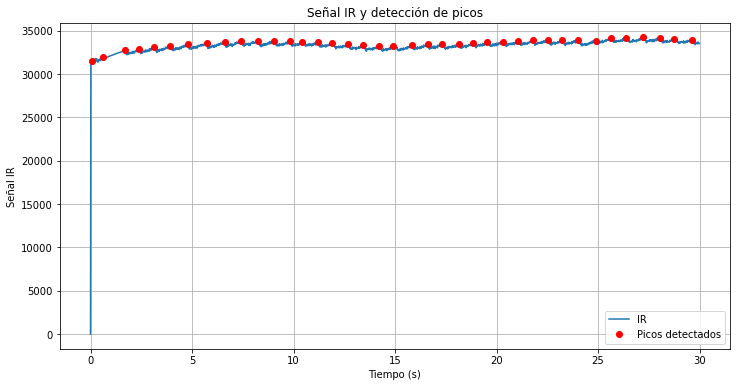

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.interpolate import interp1d

archivo_csv = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\raw_data_95_77.csv"

df = pd.read_csv(archivo_csv, delimiter=";")

# Convertir el tiempo de milisegundos a segundos para trabajar con unidades estándar.
df["Tiempo (s)"] = df["Tiempo (ms)"] / 1000  

# Estimar la frecuencia de muestreo real
df["Delta_t"] = df["Tiempo (s)"].diff() # obtiene la diferencia entre tiempos consecutivos
frecuencia_real = 1 / df["Delta_t"].median() # estima la frecuencia de muestreo real en Hz
print(f"Frecuencia de muestreo estimada: {frecuencia_real:.2f} Hz")

# Si la frecuencia de muestreo es mayor a 60 Hz, el código remuestrea la señal para evitar datos redundantes.
fs_deseado = 60  
if frecuencia_real > fs_deseado:
    # Verificar NaN antes de interpolar
    print("Valores NaN antes de interpolar:")
    print(df.isna().sum())

    # Eliminar filas con NaN
    df = df.dropna()

    # Eliminar valores duplicados en el tiempo
    df = df[~df["Tiempo (s)"].duplicated()]

    # Crear nuevo vector de tiempo con la frecuencia deseada
    tiempo_nuevo = np.arange(df["Tiempo (s)"].min(), df["Tiempo (s)"].max(), 1/fs_deseado)

    # Interpolación lineal para remuestreo
    interp_func = interp1d(df["Tiempo (s)"], df["IR"], kind="linear", fill_value="extrapolate")
    ir_resampled = interp_func(tiempo_nuevo)

    tiempo = tiempo_nuevo
    ir_signal = ir_resampled
    print(f"Se ha remuestreado la señal a {fs_deseado} Hz")
else:
    tiempo = df["Tiempo (s)"]
    ir_signal = df["IR"]


# Encuentra los picos de la señal IR, que representan latidos del corazón.
peaks, _ = find_peaks(ir_signal, distance=fs_deseado//2)  # asegura que los picos estén separados al menos 0.5 segundos 
                                                          # (porque el corazón no puede latir más rápido que eso).

# Calcula la frecuencia cardíaca usando la cantidad de picos detectados:
# len(peaks) es el número total de latidos detectados.
bpm = (len(peaks) / (tiempo[-1] - tiempo[0])) * 60  # Duración total de la señal en segundos, multiplicamos por 60 para convertir a latidos por minuto (BPM).
print(f"Frecuencia cardíaca estimada: {bpm:.2f} BPM")

# Dibuja la señal IR con los picos detectados, marcándolos en rojo ("ro").Esto permite visualizar los latidos detectados
plt.figure(figsize=(12, 6))
plt.plot(tiempo, ir_signal, label="IR")
plt.plot(tiempo[peaks], ir_signal[peaks], "ro", label="Picos detectados")
plt.xlabel("Tiempo (s)")
plt.ylabel("Señal IR")
plt.title("Señal IR y detección de picos")
plt.legend()
plt.grid()
plt.show()


Comparar frecuencia cardiaca estimada con la recogida por el pulsioxometro externo. \
Si el error es menor al 5%, la estimación es razonablemente buena. Si es mayor, podemos mejorar la detección de picos con filtros adicionales o ajustes en la detección.

In [22]:
# Extraer el pulso real del nombre del archivo
archivo_csv = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\raw_data_95_77.csv"

# Extraer el valor real de SpO₂ y HR del nombre del archivo (ejemplo: 'raw_data_93_100.csv')
nombre_archivo = archivo_csv.split("\\")[-1]
pulso_real = datos_pulsioximetro[nombre_archivo]["Pulso (BPM)"]

# Calcular el error en porcentaje
error_pulso = abs((bpm - pulso_real) / pulso_real) * 100

# Mostrar resultados
print(f"Pulso estimado: {bpm:.2f} BPM")
print(f"Pulso real: {pulso_real} BPM")
print(f"Error relativo: {error_pulso:.2f} %")


Pulso estimado: 78.04 BPM
Pulso real: 77 BPM
Error relativo: 1.36 %


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
import os
import glob
import csv

# Ruta donde están los archivos CSV
ruta_carpeta = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos"

# Función para detectar el delimitador
def detectar_delimitador(archivo):
    with open(archivo, 'r', newline='', encoding='utf-8') as f:
        muestra = f.read(1024)
        return csv.Sniffer().sniff(muestra).delimiter

# Procesar cada archivo CSV en la carpeta
for archivo_csv in glob.glob(os.path.join(ruta_carpeta, "*.csv")):
    print(f"Procesando archivo: {archivo_csv}")

    # Detectar el delimitador automáticamente
    delimitador = detectar_delimitador(archivo_csv)

    # Cargar el archivo CSV
    df = pd.read_csv(archivo_csv, delimiter=delimitador)

    # Convertir el tiempo de milisegundos a segundos
    df["Tiempo (s)"] = df["Tiempo (ms)"] / 1000  

    # Estimar la frecuencia de muestreo real
    df["Delta_t"] = df["Tiempo (s)"].diff()
    frecuencia_real = 1 / df["Delta_t"].median()
    print(f"Frecuencia de muestreo estimada: {frecuencia_real:.2f} Hz")

    # Remuestreo si la frecuencia es mayor a 60 Hz
    fs_deseado = 60  
    if frecuencia_real > fs_deseado:
        print("Valores NaN antes de interpolar:")
        print(df.isna().sum())

        # Limpiar datos
        df.dropna(inplace=True)
        df = df[~df["Tiempo (s)"].duplicated()]

        # Crear nuevo vector de tiempo con la frecuencia deseada
        tiempo_nuevo = np.arange(df["Tiempo (s)"].min(), df["Tiempo (s)"].max(), 1/fs_deseado)

        # Interpolación lineal para remuestreo
        interp_func = interp1d(df["Tiempo (s)"], df["IR"], kind="linear", fill_value="extrapolate")
        ir_resampled = interp_func(tiempo_nuevo)

        tiempo = tiempo_nuevo
        ir_signal = ir_resampled
        print(f"Se ha remuestreado la señal a {fs_deseado} Hz")
    else:
        tiempo = df["Tiempo (s)"]
        ir_signal = df["IR"]

    # Encontrar los picos (latidos)
    peaks, _ = find_peaks(ir_signal, distance=fs_deseado // 2)

    # Calcular la frecuencia cardíaca (BPM)
    bpm = (len(peaks) / (tiempo.iloc[-1] - tiempo.iloc[0])) * 60
    print(f"Frecuencia cardíaca estimada: {bpm:.2f} BPM")

    # Graficar la señal con los picos
    plt.figure(figsize=(12, 6))
    plt.plot(tiempo, ir_signal, label="IR")
    plt.plot(tiempo[peaks], ir_signal[peaks], "ro", label="Picos detectados")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Señal IR")
    plt.title(f"Señal IR y detección de picos ({os.path.basename(archivo_csv)})")
    plt.legend()
    plt.grid()
    plt.show()


### Enfoque basado en detectar los picos del PPG

Frecuencia cardíaca calculada: 88.11 BPM


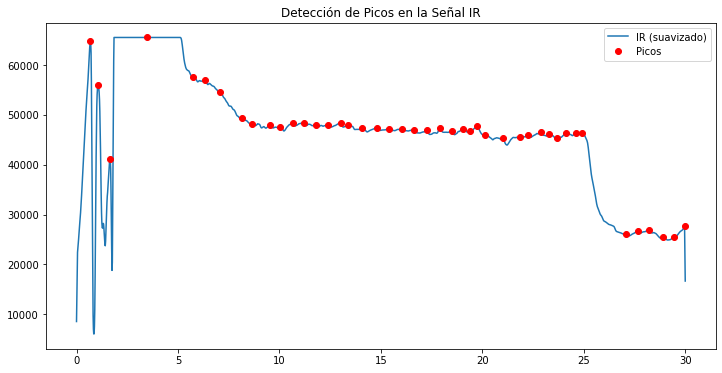

In [7]:
from scipy.signal import find_peaks

# Detectar picos en la señal IR
picos, _ = find_peaks(df["IR_suave"], height=1000, distance=20)

# Calcular el tiempo entre picos (periodo del pulso)
tiempos_picos = df["Tiempo (s)"].iloc[picos].values
intervalos = np.diff(tiempos_picos)  # Diferencia entre picos (en segundos)

# Calcular la frecuencia cardíaca (HR en latidos por minuto)
hr_calculado = 60 / np.mean(intervalos)
print(f"Frecuencia cardíaca calculada: {hr_calculado:.2f} BPM")

# Visualizar los picos
plt.figure(figsize=(12, 6))
plt.plot(df["Tiempo (s)"], df["IR_suave"], label="IR (suavizado)")
plt.plot(tiempos_picos, df["IR_suave"].iloc[picos], "ro", label="Picos")
plt.legend()
plt.title("Detección de Picos en la Señal IR")
plt.show()


## Saturación de oxígeno (SpO₂)

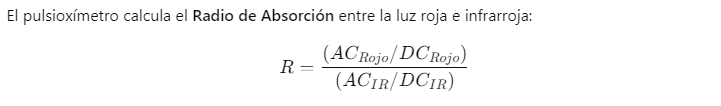

Donde:

- AC (componente pulsátil) → Parte variable de la señal debida al flujo sanguíneo.
- DC (componente no pulsátil) → Absorción constante de los tejidos.

Luego, usando una ecuación empírica basada en calibraciones clínicas:

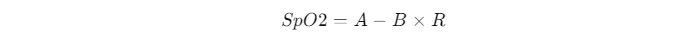

(A y B son constantes determinadas experimentalmente).

In [8]:
# Función para calcular SpO2
def calcular_spo2(ir, red):
    ac_ir = np.std(ir)    # Componente AC (desviación estándar)
    dc_ir = np.mean(ir)   # Componente DC (media)
    ac_red = np.std(red)
    dc_red = np.mean(red)

    # Calcular el coeficiente R
    R = (ac_red / dc_red) / (ac_ir / dc_ir)

    # Fórmula empírica
    spo2 = 110 - 25 * R
    return spo2

spo2_calculado = calcular_spo2(df["IR_suave"], df["RED_suave"])
print(f"Saturación de oxígeno estimada: {spo2_calculado:.2f} %")


Saturación de oxígeno estimada: 108.47 %


## Evaluar el error

In [9]:
# Calcular el error
error_spo2 = abs(spo2_calculado - spo2_real)
error_hr = abs(hr_calculado - hr_real)

print(f"Error en SpO₂: {error_spo2:.2f} %")
print(f"Error en HR: {error_hr:.2f} BPM")


Error en SpO₂: 15.47 %
Error en HR: 11.89 BPM


Valores reales: SpO₂ = 92, HR = 76
   Tiempo (ms)     IR  AMB_IR   RED  AMB_RED
0            0      0       0  6748        0
1           16  35910    2146  7975     2134
2           33  35954    2195  8003     2176
3           50  35996    2243  8047     2221
4           66  36052    2281  8106     2257


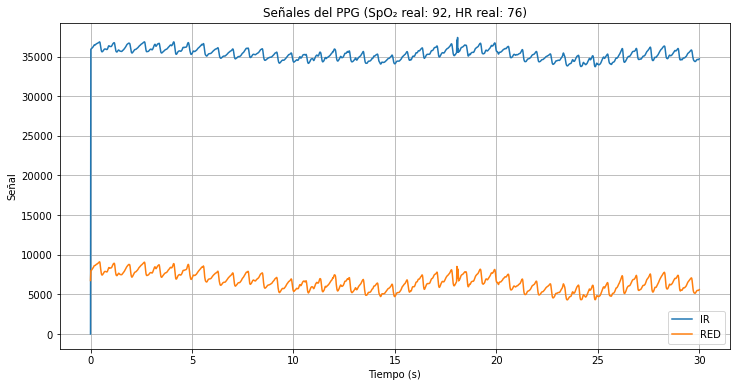

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import re

# Ruta del archivo específico
archivo_csv = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\raw_data_92_76.csv"

# Extraer el valor real de SpO₂ y HR del nombre del archivo (ejemplo: 'raw_data_93_100.csv')
nombre_archivo = archivo_csv.split("\\")[-1]
spo2_real, hr_real = map(int, re.findall(r'\d+', nombre_archivo)[-2:])

print(f"Valores reales: SpO₂ = {spo2_real}, HR = {hr_real}")

# Cargar el CSV
df = pd.read_csv(archivo_csv)

# Verificar que el CSV tiene las columnas correctas
print(df.head())

# Asegurarnos de que las columnas esperadas estén en el CSV
if not all(col in df.columns for col in ["Tiempo (ms)", "IR", "RED"]):
    raise ValueError("El CSV no tiene las columnas esperadas: 'Tiempo (ms)', 'IR', 'RED'.")

# Convertir la columna de tiempo a segundos
df["Tiempo (s)"] = df["Tiempo (ms)"] / 1000

# Visualizar las señales IR y RED
plt.figure(figsize=(12, 6))
plt.plot(df["Tiempo (s)"], df["IR"], label="IR")
plt.plot(df["Tiempo (s)"], df["RED"], label="RED")
plt.xlabel("Tiempo (s)")
plt.ylabel("Señal")
plt.legend()
plt.title(f"Señales del PPG (SpO₂ real: {spo2_real}, HR real: {hr_real})")
plt.grid()
plt.show()


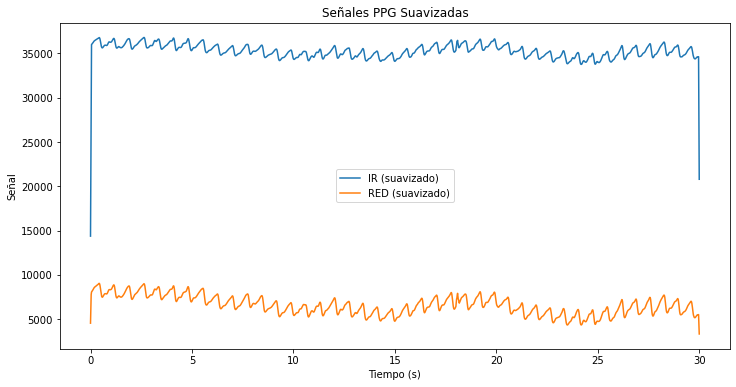

In [2]:
# Eliminar filas con valores NaN (si los hay)
df.dropna(inplace=True)

# Suavizar las señales (filtro media móvil)
def suavizar(senal, ventana=5):
    return np.convolve(senal, np.ones(ventana)/ventana, mode='same')

df["IR_suave"] = suavizar(df["IR"])
df["RED_suave"] = suavizar(df["RED"])

# Visualizar las señales suavizadas
plt.figure(figsize=(12, 6))
plt.plot(df["Tiempo (s)"], df["IR_suave"], label="IR (suavizado)")
plt.plot(df["Tiempo (s)"], df["RED_suave"], label="RED (suavizado)")
plt.xlabel("Tiempo (s)")
plt.ylabel("Señal")
plt.legend()
plt.title("Señales PPG Suavizadas")
plt.show()


Frecuencia cardíaca calculada: 89.40 BPM


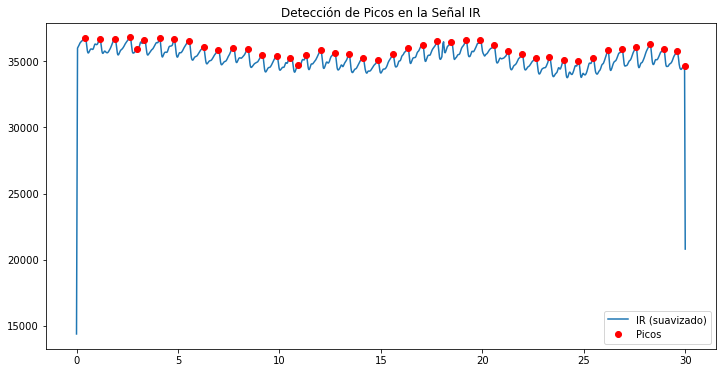

In [3]:
from scipy.signal import find_peaks

# Detectar picos en la señal IR
picos, _ = find_peaks(df["IR_suave"], height=1000, distance=20)

# Calcular el tiempo entre picos (periodo del pulso)
tiempos_picos = df["Tiempo (s)"].iloc[picos].values
intervalos = np.diff(tiempos_picos)  # Diferencia entre picos (en segundos)

# Calcular la frecuencia cardíaca (HR en latidos por minuto)
hr_calculado = 60 / np.mean(intervalos)
print(f"Frecuencia cardíaca calculada: {hr_calculado:.2f} BPM")

# Visualizar los picos
plt.figure(figsize=(12, 6))
plt.plot(df["Tiempo (s)"], df["IR_suave"], label="IR (suavizado)")
plt.plot(tiempos_picos, df["IR_suave"].iloc[picos], "ro", label="Picos")
plt.legend()
plt.title("Detección de Picos en la Señal IR")
plt.show()


In [4]:
# Función para calcular SpO2
def calcular_spo2(ir, red):
    ac_ir = np.std(ir)    # Componente AC (desviación estándar)
    dc_ir = np.mean(ir)   # Componente DC (media)
    ac_red = np.std(red)
    dc_red = np.mean(red)

    # Calcular el coeficiente R
    R = (ac_red / dc_red) / (ac_ir / dc_ir)

    # Fórmula empírica
    spo2 = 110 - 25 * R
    return spo2

spo2_calculado = calcular_spo2(df["IR_suave"], df["RED_suave"])
print(f"Saturación de oxígeno estimada: {spo2_calculado:.2f} %")


Saturación de oxígeno estimada: -30.84 %
